In [1]:
# First some imports that we'll use below
from __future__ import print_function
import treecorr
import fitsio
import numpy
import math
import time
import pprint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy import stats
#import plotly.plotly as py
#import plotly.graph_objs as go
from astropy.table import Table
from scipy.stats import chisquare
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
from astropy.cosmology import WMAP5 as cosmo
from astropy import cosmology

In [4]:
galaxy_sample = 'des40a/example/new_example.1_truth.20.fits' # fits file with galaxy sample
data = Table.read(galaxy_sample) #Tbale displaying ra,dec,redshift,etc.

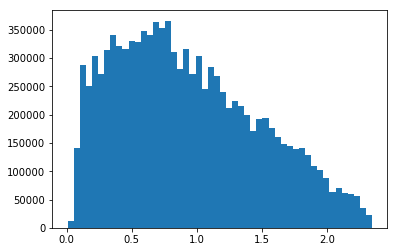

In [5]:
#histogram of redshift
plt.hist(data['Z'], bins = 50) 
plt.show()

In [6]:
z= numpy.array(data['Z'])
ra = numpy.array (data['RA'])
dec = numpy.array(data['DEC'])
mask = ((dec<-46) & (dec>-49) & (ra >8 ) & (ra<11)) # ra and dec restrictions
data = data[mask] #new galaxy sample with mask applied
z= numpy.array(data['Z'])
ra = numpy.array (data['RA'])
dec = numpy.array(data['DEC'])
new_file = 'des40a/whole/nocut.fits'
data.write(new_file) #writes out fits file with new galaxy sample with mask
# create galaxy catalog with treecorr
galaxy_catalog = treecorr.Catalog(new_file, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg')
print (len(data), numpy.max(ra), numpy.max(dec), numpy.max(z), numpy.min(ra), numpy.min(dec), numpy.min(z))


1230041 11.0 -46.0 2.34489 8.0 -49.0 0.0125873


In [7]:
# sort data in order of increasing redshift
sorted_data = sorted(data, key= lambda redshift:redshift['Z'])

In [8]:
# create random catalog
ra_min = numpy.min(galaxy_catalog.ra)
ra_max = numpy.max(galaxy_catalog.ra)
dec_min = numpy.min(galaxy_catalog.dec)
dec_max = numpy.max(galaxy_catalog.dec)
rand_ra = numpy.random.uniform(ra_min, ra_max, len(data)*10) 
rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data)*10) 
rand_dec = numpy.arcsin(rand_sindec) #convert back to dec
rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians') 

0.13962637394184502

In [7]:
dist = cosmo.comoving_distance(0.4)
print(dist)
d_ra = (numpy.max(ra) - numpy.min(ra))*180/numpy.pi*dist
d_dec = (numpy.max(dec) - numpy.min(dec))*180/numpy.pi*dist
area = d_ra*d_dec
print(64*numpy.pi, area)

1557.32091112 Mpc
201.06192983 71653768207.5 Mpc2


In [9]:
# set redshift ranges for each of the 25 bins so each bin has the same amount of galaxies
z_min = []
z_max = []
for i in range (0,25):
    zmin = sorted_data[i*(len(data)/25-1)]['Z']
    zmax = sorted_data[(i+1)*(len(data)/25-1)]['Z']
    z_min.append(zmin)
    z_max.append(zmax)

In [10]:
#set the theta min and theta max for each redshift to a physical range of 0.3Mpc - 2.5Mpc
z_distance = []
theta_min = []
theta_max = []
for red in range (0,25):
    d1 = cosmo.comoving_distance([z_max[red]])
    z_distance.append((d1.value))
    thetamin = 0.3*180/(numpy.pi * z_distance[red])
    thetamax = 2.5*180/(numpy.pi * z_distance[red])
    theta_min.append(thetamin)
    theta_max.append(thetamax)


In [11]:
#set for 9 boxes of equal area in jackknife
ra_step = []
dec_step = []
ra_step.append(numpy.min(ra))
dec_step.append(numpy.min(dec))
for r in range (0,3):
    rastep = (r+1)*(numpy.max(ra) - numpy.min(ra))/3
    rastep += numpy.min(ra)
    decstep = (r+1)*(numpy.max(dec) - numpy.min(dec))/3
    decstep += numpy.min(dec)
    ra_step.append(rastep)
    dec_step.append(decstep)

In [16]:
#jackknife ffunction with 9 subsamples
def jack(i,j,boxID,mask,zd):
    new_xi = []
    #new mask that eliminates one of the 9 subsamples (boxes) and then creates new catalog
    new_mask = ((mask) & ((((ra>ra_step[i+1]) ^ (ra<ra_step[i])) & ((dec>dec_step[j+1])^ (dec<dec_step[j]))) ^ (((ra>ra_step[i+1]) ^ (ra<ra_step[i])) ^ ((dec>dec_step[j+1])^ (dec<dec_step[j])))))
    nameID = boxID + str(3*j) + str(i) + 'jack'
    jack_name = 'des40a/whole/' + nameID + '.fits'
    data[new_mask].write(jack_name)
    galaxy_catalog = treecorr.Catalog(jack_name, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg')
    ra_min = numpy.min(galaxy_catalog.ra)
    ra_max = numpy.max(galaxy_catalog.ra)
    dec_min = numpy.min(galaxy_catalog.dec)
    dec_max = numpy.max(galaxy_catalog.dec)
    rand_ra = numpy.random.uniform(ra_min, ra_max, len(data[new_mask])*10) 
    rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data[new_mask])*10)  
    rand_dec = numpy.arcsin(rand_sindec)
    rand_ra_pi = rand_ra*180 / numpy.pi
    rand_dec_pi = (rand_dec)*180 / numpy.pi
    # mask for random catalog that eliminates the same box as the one from galaxy_sample
    ran_mask = (((((rand_ra_pi>ra_step[i+1]) ^ (rand_ra_pi<ra_step[i])) & ((rand_dec_pi>dec_step[j+1])^ (rand_dec_pi<dec_step[j]))) ^ (((rand_ra_pi>ra_step[i+1]) ^ (rand_ra_pi<ra_step[i])) ^ ((rand_dec_pi>dec_step[j+1])^ (rand_dec_pi<dec_step[j])))))
    rand_ra = rand_ra[ran_mask]
    rand_dec = rand_dec[ran_mask]
    rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
    size = str(len(data[new_mask]))
    size_int = len(data[new_mask])  
    dd = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees')
    rr = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees')
    dr = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees') 
    dd.process(galaxy_catalog)
    rr.process(rand_catalog)
    dr.process(galaxy_catalog,rand_catalog) 
    xi, varxi = dd.calculateXi(rr,dr)
    return (xi)

In [17]:
A_value = [] # array that will store values of A for each redshift bin (given by polyfit)
g_value = [] # array that will store values of gamma for each redshift bin (given by polyfit)
A_err = []   # error on each measurment of A (given by polyfit)
g_err = []   # error on each measurment of gamma (given by polyfit)
r_value = [] # vales for theta in each bin
xi_value = []  # stores values of correlation function for each redshift bin
yfit_eq = []   # stores the best fit line for each redshift bin (using values of A and gamma from polyfit) 
sig_value = [] # treecorr error on each value of xi (underestimated error)
N_size = []   # string with the number of galaxies in each bin
DD_val = []   # stores values of DD for each bin
RR_val= []    # stores values of RR for each bin
N_sizeint =[] # number of galaxies as an int
new_xi = []   # 9 xi jackknife values for each angular bin
A_logerr = [] # error on logA given by polyfit

In [18]:
def tree2():
   for zd in range (0,25):
       boxID = str(zd+1)
       mask = (z>(z_min[zd])) & (z<(z_max[zd]))
       file_name = 'des40a/whole/' + boxID + '.fits' 
       print (file_name) 
       data[mask].write(file_name)
       galaxy_catalog = treecorr.Catalog(file_name, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg') 
       ra_min = numpy.min(galaxy_catalog.ra)
       ra_max = numpy.max(galaxy_catalog.ra)
       dec_min = numpy.min(galaxy_catalog.dec)
       dec_max = numpy.max(galaxy_catalog.dec)
       rand_ra = numpy.random.uniform(ra_min, ra_max, len(data[mask])*10) 
       rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data[mask])*10)  
       rand_dec = numpy.arcsin(rand_sindec) #convert back to dec
       rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians') 
       size = str(len(data[mask]))
       size_int = len(data[mask])  
       dd = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees')
       rr = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees')
       dr = treecorr.NNCorrelation(min_sep=theta_min[zd], max_sep=theta_max[zd], nbins=10, sep_units='degrees') 
       dd.process(galaxy_catalog)
       rr.process(rand_catalog)
       dr.process(galaxy_catalog,rand_catalog) 
       xi, varxi = dd.calculateXi(rr,dr) 
       fits_name = 'des40a/whole/whole' + boxID + '.fits' 
       dd.write (fits_name,rr, dr)
       dd_read = Table.read(fits_name)
       DD = dd_read['DD']
       RR = dd_read['RR'] 
       r = numpy.exp(dd.meanlogr)
       sig = numpy.sqrt(varxi)
       logr = numpy.log(numpy.absolute(r))
       logxi = numpy.log(numpy.absolute(xi))
       m, c = numpy.polyfit(logr, logxi, 1)
       y_fit = numpy.exp(m*logr + c)
       gamma = 1-m
       A = numpy.exp(c)
       r_value.append(r)
       xi_value.append(xi)
       sig_value.append(sig)
       N_size.append(size)
       N_sizeint.append(size_int)
       DD_val.append(DD)
       RR_val.append(RR) 
       p, V = numpy.polyfit(logr, logxi, 1, cov=True) 
       m_error = numpy.sqrt(V[0][0])
       c_error = numpy.sqrt(V[1][1])
       gamma_error = gamma - (1-(m-m_error))
       A_error = A - numpy.exp(c-c_error)
       yfit_eq.append(y_fit)
       A_value.append(A)
       g_value.append(gamma)
       A_err.append (A_error)
       A_logerr.append(c_error)
       g_err.append (numpy.abs(gamma_error))
       newxi = [] # xi values for each jackknife run
       final_jack= [] # xi values for each angular bin in jackknife (each anguar bin has 9 values)
       print ( 'A value = %.6f' %(A), '+/- %.6f'  %(A_error), 'Gamma value = %.6f..'%(gamma), '+/- %.6f'  %(gamma_error))
       for i in range (0,3):
            for j in range (0,3):
                newxi.append(numpy.array(jack(i,j, boxID,mask,zd)))
       for n in range (0,xi.size) :
           jack_xi=[] # goes through each angular bin of each jackknife and stores the xi values
           for count in range (0,9): 
               jack_xi.append(newxi[count][n])    
           final_jack.append(jack_xi)
       new_xi.append(final_jack)

In [19]:
tree2()

des40a/whole/1.fits
A value = 0.032860 +/- 0.003344 Gamma value = 1.941237.. +/- -0.039817
des40a/whole/2.fits
A value = 0.066209 +/- 0.012617 Gamma value = 1.787993.. +/- -0.071135
des40a/whole/3.fits
A value = 0.051227 +/- 0.003973 Gamma value = 1.777010.. +/- -0.025169
des40a/whole/4.fits
A value = 0.013975 +/- 0.002929 Gamma value = 2.035424.. +/- -0.068915
des40a/whole/5.fits
A value = 0.102811 +/- 0.008616 Gamma value = 1.639240.. +/- -0.024780
des40a/whole/6.fits
A value = 0.022371 +/- 0.004043 Gamma value = 1.956214.. +/- -0.054692
des40a/whole/7.fits
A value = 0.070068 +/- 0.008048 Gamma value = 1.702030.. +/- -0.032492
des40a/whole/8.fits
A value = 0.090844 +/- 0.007568 Gamma value = 1.673064.. +/- -0.022736
des40a/whole/9.fits
A value = 0.090685 +/- 0.008314 Gamma value = 1.638191.. +/- -0.024643
des40a/whole/10.fits
A value = 0.028874 +/- 0.002864 Gamma value = 1.855326.. +/- -0.026323
des40a/whole/11.fits
A value = 0.076863 +/- 0.007432 Gamma value = 1.682748.. +/- -0.0253

In [20]:
# this function calculates the average value of xi for each bin and stderr at each redshift
def_xi = []
def_err = []
for point in range (0, len(new_xi)):
    final_xi = []
    final_err = []
    for nu in range (0, len(new_xi[point])):
        test_statistic = numpy.mean
        jack_point = numpy.array(new_xi[point][nu])
        estimate, bias, stderr, conf_interval = jackknife_stats(jack_point, test_statistic, 0.95)
        final_xi.append (estimate)
        final_err.append (stderr)
    def_xi.append(final_xi)
    def_err.append(stderr)

In [21]:
cov_err = [] # sqrt of diagonal elements of covariance matrix, aka the error on each value of xi for each bin
cov_diag = [] # diag elements of the cov matrix (the variance)
for red in range (0,25):
    cov_mat = []
    cov_var = []
    for cell in range (0, xi_value[red].size):    
        sum_cov = 0
        for num in range (0,9):
            sub = xi_value[red][cell] - new_xi[red][cell][num]
            cov = math.pow(sub, 2)
            sum_cov+=cov
        cot = math.sqrt(sum_cov*8/9)
        cot_var = sum_cov*8/9
        cov_var.append(cot_var)
        cov_mat.append((cot))
    cov_err.append(cov_mat)
    cov_diag.append(cov_var)

In [22]:
covi_def = [] #entire covariance matrix
for dif in range (0,25):
    covi_final = []
    for red in range (0,xi_value[dif].size):
        covi_mat = []
        count = 0
        for cell in range (0,xi_value[dif].size):    
            sum_covi = 0
            for num in range (0,9):
                subi = (xi_value[dif][count] - new_xi[dif][count][num])
                subj = (xi_value[dif][red] - new_xi[dif][red][num])
                covi = subi*subj
                sum_covi+=covi
            tot = (sum_covi*8/9)
            covi_mat.append((tot))
            count =count+1
        covi_final.append(covi_mat)
    covi_def.append(covi_final)

In [23]:
corr_def = [] #entire correleation matrix. This function converts the cov matrix into the correleation matrix
for cov in range (0,25):
    covinv = numpy.linalg.inv(numpy.diag(cov_err[cov]))
    corr = numpy.dot(covinv ,numpy.dot(covi_def[cov], covinv))
    corr_def.append(corr)

In [24]:
log_error = [] # convert linear error for xi values into log error
for redshift in range (0,25):
    new_error = []
    for den in range (0,len(new_xi[redshift])):
        new_error.append (0.434*cov_err[redshift][den]/xi_value[redshift][den])
    log_error.append(new_error)

In [52]:
fin_A = [] # value of A using Push(2002) calculation for best fit line
fin_gamma = [] # value fo gamma using same method
fin_Aerr = [] # respective errors using Push (2002)
fin_gerr = []
for shift in range (0,25): 
    new_A = []
    new_gamma = []
    s_sum = 0
    sx_sum = 0
    sy_sum = 0
    sxx_sum = 0
    sxy_sum = 0
    for num in range (0,len(new_xi[shift])):
        err = math.pow(log_error[shift][num],2)
        s = 1/err
        s_sum +=s
        sx = numpy.log(r_value[shift][num])/err
        sx_sum += sx
        sy = numpy.log(numpy.absolute(xi_value[shift][num]))/err
        sy_sum += sy
        sxx = sx = math.pow(numpy.log(r_value[shift][num]),2)/err
        sxx_sum += sxx 
        sxy = numpy.log(numpy.absolute(xi_value [shift][num]))*numpy.log(r_value[shift][num])/err
        sxy_sum += sxy
    delta = s_sum*sxx_sum - math.pow(sx_sum,2)
    a = (sxx_sum*sy_sum - sx_sum*sxy_sum)/delta
    b = (s_sum * sxy_sum - sx_sum*sy_sum)/delta
    err_alog = numpy.sqrt(sxx_sum/delta)
    err_a = err_alog * numpy.exp(a)/0.434
    err_b = numpy.sqrt(s_sum/delta)
    new_A.append(numpy.exp(a))
    new_gamma.append(1-b)
    fin_A.append(numpy.exp(a))
    fin_gamma.append(1-b)
    fin_Aerr.append(err_a)
    fin_gerr.append(err_b)


In [26]:
A_newerr = [] # error on logA from polyfit into standard error
for dn in range (0,25):
    newa = A_logerr[dn]* A_value[dn]/0.434
    A_newerr.append(newa)

In [27]:
fin_fit = [] # best fit line using values of A and gamma from push
for l in range (0,25):
    g = sum(fin_gamma[l])
    slope = 1-g
    new_fit = numpy.exp((slope)*numpy.log(r_value[l]) + numpy.log(fin_A[l]))
    fin_fit.append(new_fit)

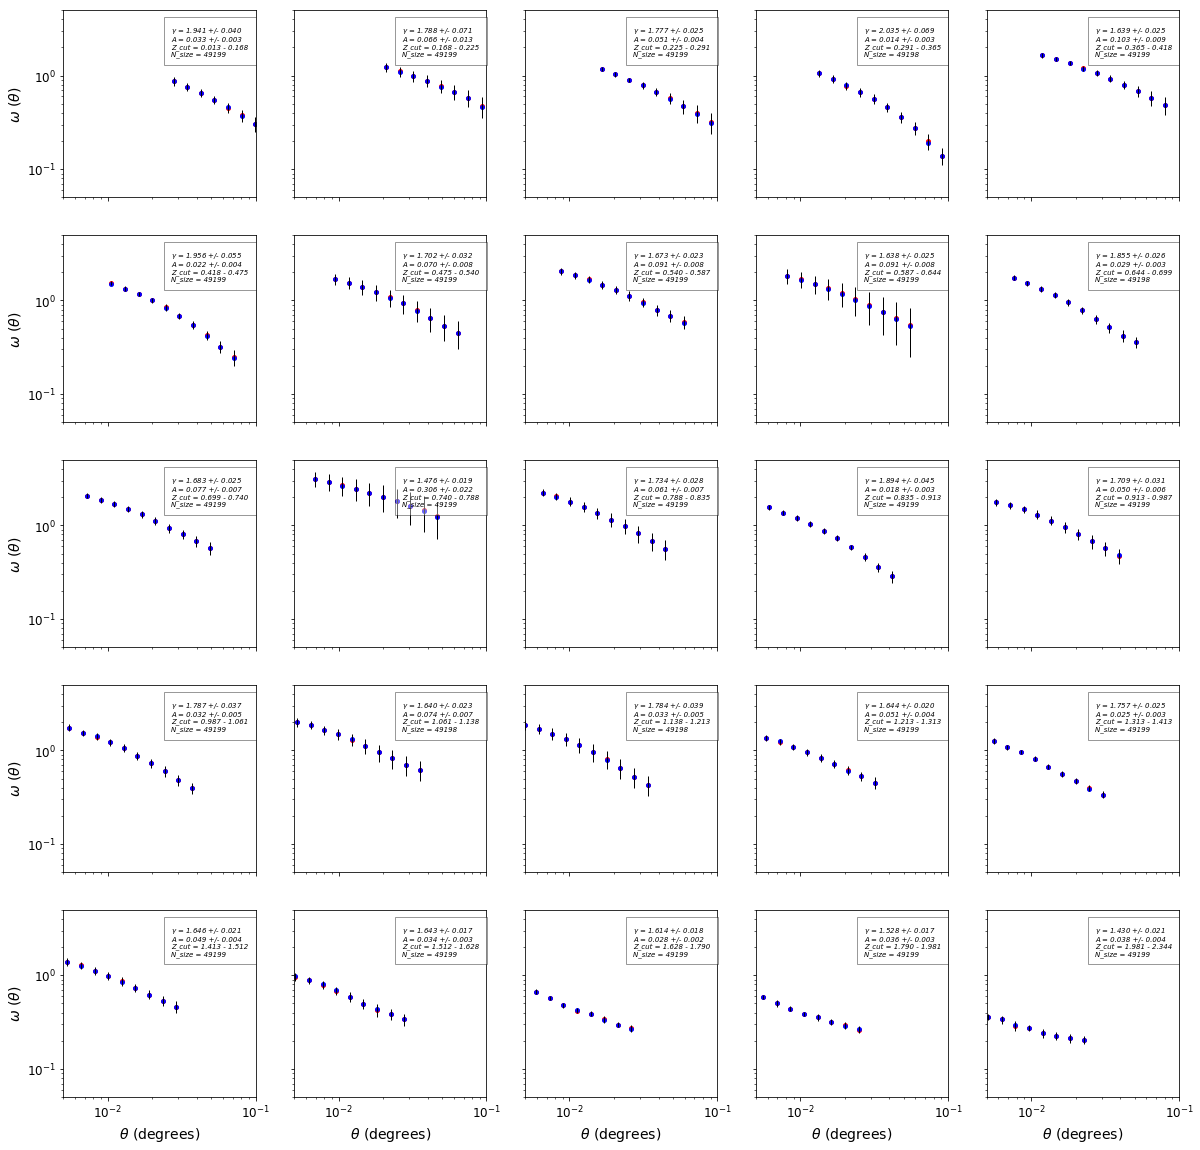

In [31]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):
        #ax[i, j].plot(r_value[rep[i] + j], yfit_eq[rep[i] + j], color = 'green', lw = 2)
        ax[i,j].scatter(r_value[rep[i] + j], xi_value[rep[i] + j], color='red', s = 15)
        ax[i,j].scatter(r_value[rep[i] + j], def_xi[rep[i] + j], color='blue', s = 15)
        #ax[i,j].scatter(r_value[rep[i] + j], -xi_value[rep[i] + j], color='blue', s = 15)
        ax[i,j].errorbar(r_value[rep[i] + j], xi_value[rep[i] + j], yerr = cov_err[rep[i] + j], color='black', lw=1, ls='')
        #ax[i,j].errorbar(r_value[rep[i] + j], -xi_value[rep[i] + j], yerr= xi_err[rep[i] + j], color='black', lw=1, ls='')                 
        ax[4,j].set_xlabel(r'$\theta$ (degrees)', fontsize= 14)
        ax[i,0].set_ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
        #ax[i,j].set_xscale('linear')
        #ax[i,j].set_yscale('linear')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log', nonposy='clip')
        ax[i,j].tick_params (axis = 'both', labelsize = 12)
        ax[i,j].set_xlim(0.005, 0.1)
        ax[i,j].set_ylim(0.05, 5)
        ax[i,j].text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[rep[i] + j]) + ' +/- %.3f' %(g_err[rep[i] + j])
          + '\n' + r'A = %.3f' % (A_value[rep[i] + j]) + ' +/- %.3f' %(A_err[rep[i] + j])
          + '\n' + r'Z_cut = %.3f' % (z_min[rep[i] + j]) + ' - %.3f' % (z_max[rep[i] + j])
          + '\n' + 'N_size = ' + (N_size[rep[i] + j]),
          #+ '\n' + 'X/ndof = %.3f' %(chisqr[rep[i] + j]) 
          style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})
#fig.savefig('des40a/picss.png')

In [117]:
def spec(num):  # function to analyze a specific z bin  
    #plt.plot(r_value[num-1], yfit_eq[num-1], color = 'green', lw = 2)
    plt.plot(r_value[num-1], fin_fit[num-1], color = 'red', lw = 2)
    plt.scatter(r_value[num-1], xi_value[num-1], color='blue', s = 15)
    plt.errorbar(r_value[num -1], xi_value[num-1], yerr = (cov_err[num-1]), color='black', lw=1, ls='')
    plt.xlabel(r'$\theta$ (degrees)', fontsize= 14)
    plt.ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
    #plt.xscale('linear')
    #plt.yscale('linear')
    plt.xscale('log')
    plt.yscale('log', nonposy='clip')
    plt.tick_params (axis = 'both', labelsize = 12)
    plt.xlim(numpy.min(r_value[num -1]),numpy.max(r_value[num -1]))
    plt.ylim(numpy.min(xi_value[num -1]),numpy.max(xi_value[num -1]))
    #plt.text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[num-1]) + ' +/- %.3f' %(g_err[num-1])
    #+ '\n' + r'A = %.3f' % (A_value[num-1]) + ' +/- %.3f' %(A_err[num-1])
    #+ '\n' + r'Z_cut = %.3f' % (z_min[num-1]) + ' - %.3f' % (z_max[num-1])
    #+ '\n' + 'N_size = ' + (N_size[num-1]),
    #+ '\n' + 'X/ndof = %.3f' %(chisqr[num -1]) 
    #style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})

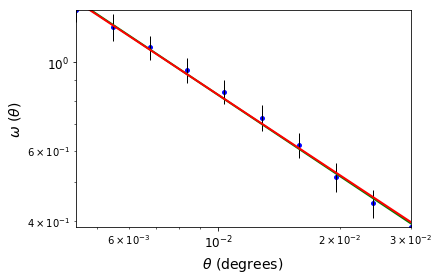

In [120]:
spec(20)

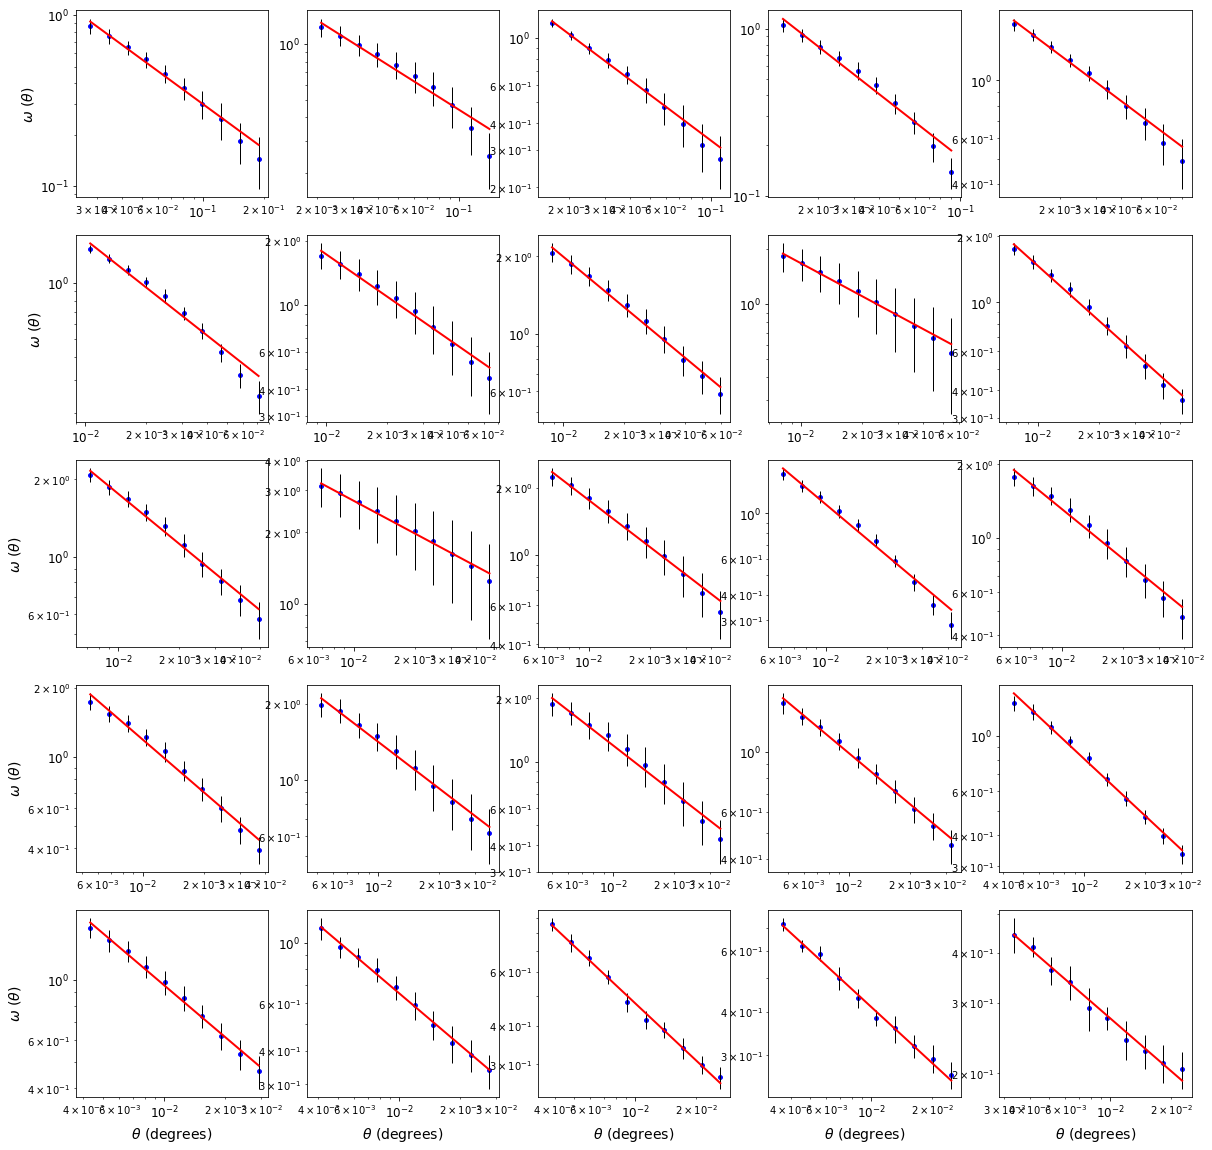

In [96]:
fig, ax = plt.subplots(5, 5,figsize = (20,20)) #log-log scale of autocorrelation function fo each z bin
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):
        ax[i, j].plot(r_value[rep[i] + j], fin_fit[rep[i] + j], color = 'red', lw = 2)
        ax[i,j].scatter(r_value[rep[i] + j], xi_value[rep[i] + j], color='blue', s = 15)
        ax[i,j].errorbar(r_value[rep[i] + j], xi_value[rep[i] + j], yerr = (cov_err[rep[i] + j]), color='black', lw=1, ls='')              
        ax[4,j].set_xlabel(r'$\theta$ (degrees)', fontsize= 14)
        ax[i,0].set_ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
        #ax[i,j].set_xscale('linear')
        #ax[i,j].set_yscale('linear')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log', nonposy='clip')
        ax[i,j].tick_params (axis = 'both', labelsize = 12)
        #ax[i,j].set_xlim(0.005, 0.1)
        #ax[i,j].set_ylim(0.05, 4)
        #ax[i,j].text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[rep[i] + j]) + ' +/- %.3f' %(g_err[rep[i] + j])
          #+ '\n' + r'A = %.3f' % (A_value[rep[i] + j]) + ' +/- %.3f' %(A_err[rep[i] + j])
          #+ '\n' + r'Z_cut = %.3f' % (z_min[rep[i] + j]) + ' - %.3f' % (z_max[rep[i] + j])
          #+ '\n' + 'N_size = ' + (N_size[rep[i] + j]),
          #+ '\n' + 'X/ndof = %.3f' %(chisqr[rep[i] + j]) 
          #style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})
fig.savefig('des40a/redshift_grid.png')

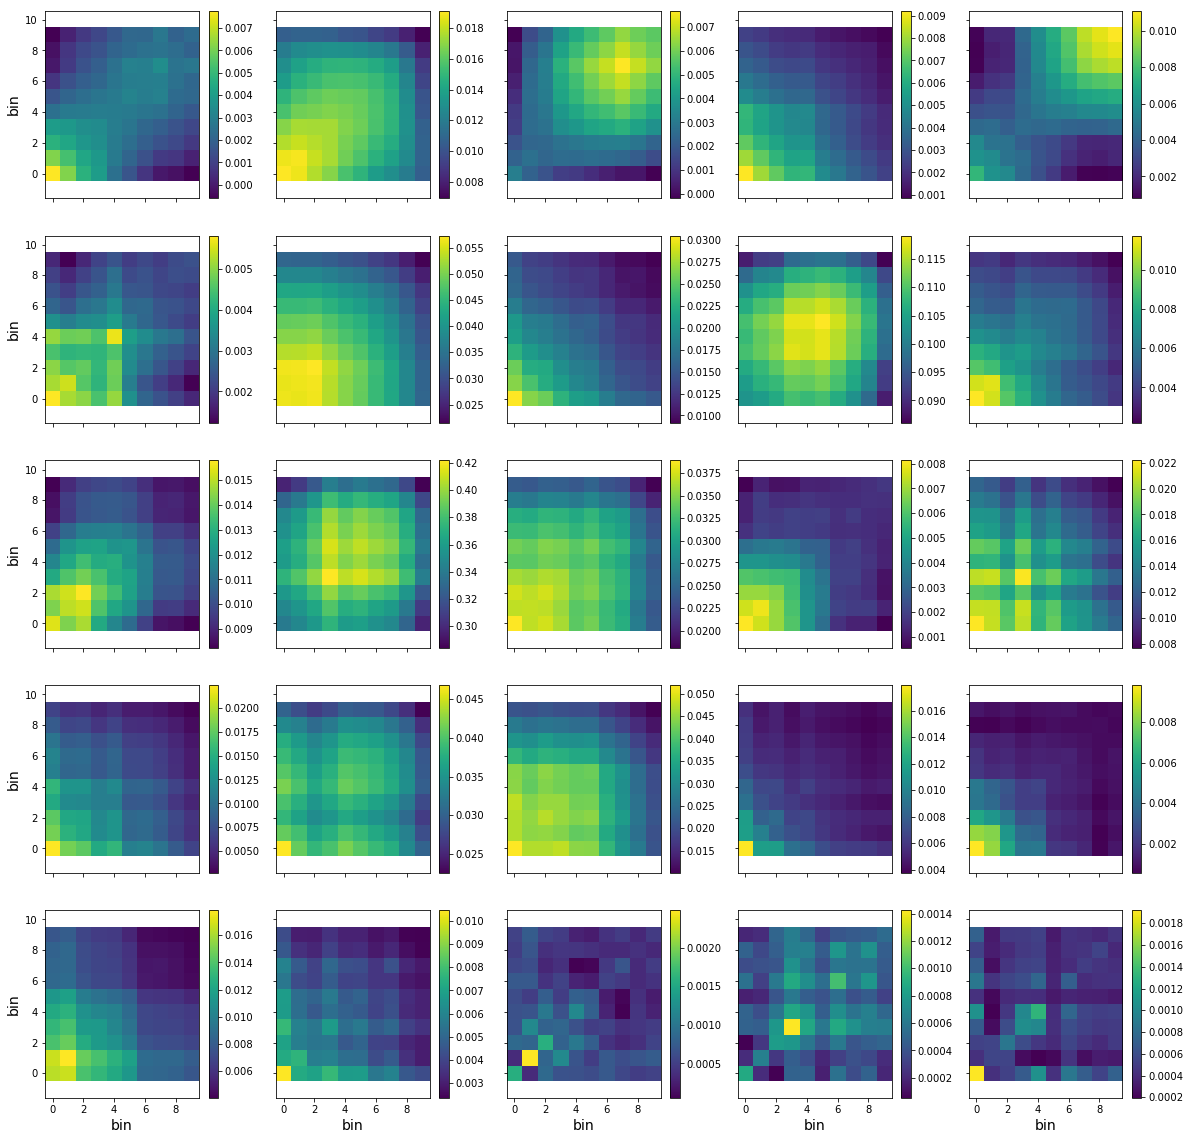

In [33]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20)) # covariance matrix for each z bin
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):      
        cax = ax[i, j].imshow(covi_def[rep[i] + j], aspect = 'equal',interpolation = None, origin = 'lower')
        ax[4,j].set_xlabel('bin', fontsize= 14)
        ax[i,0].set_ylabel('bin', fontsize = 14)
        fig.colorbar(cax , ax=ax[i, j])
#fig.savefig('picss.png')

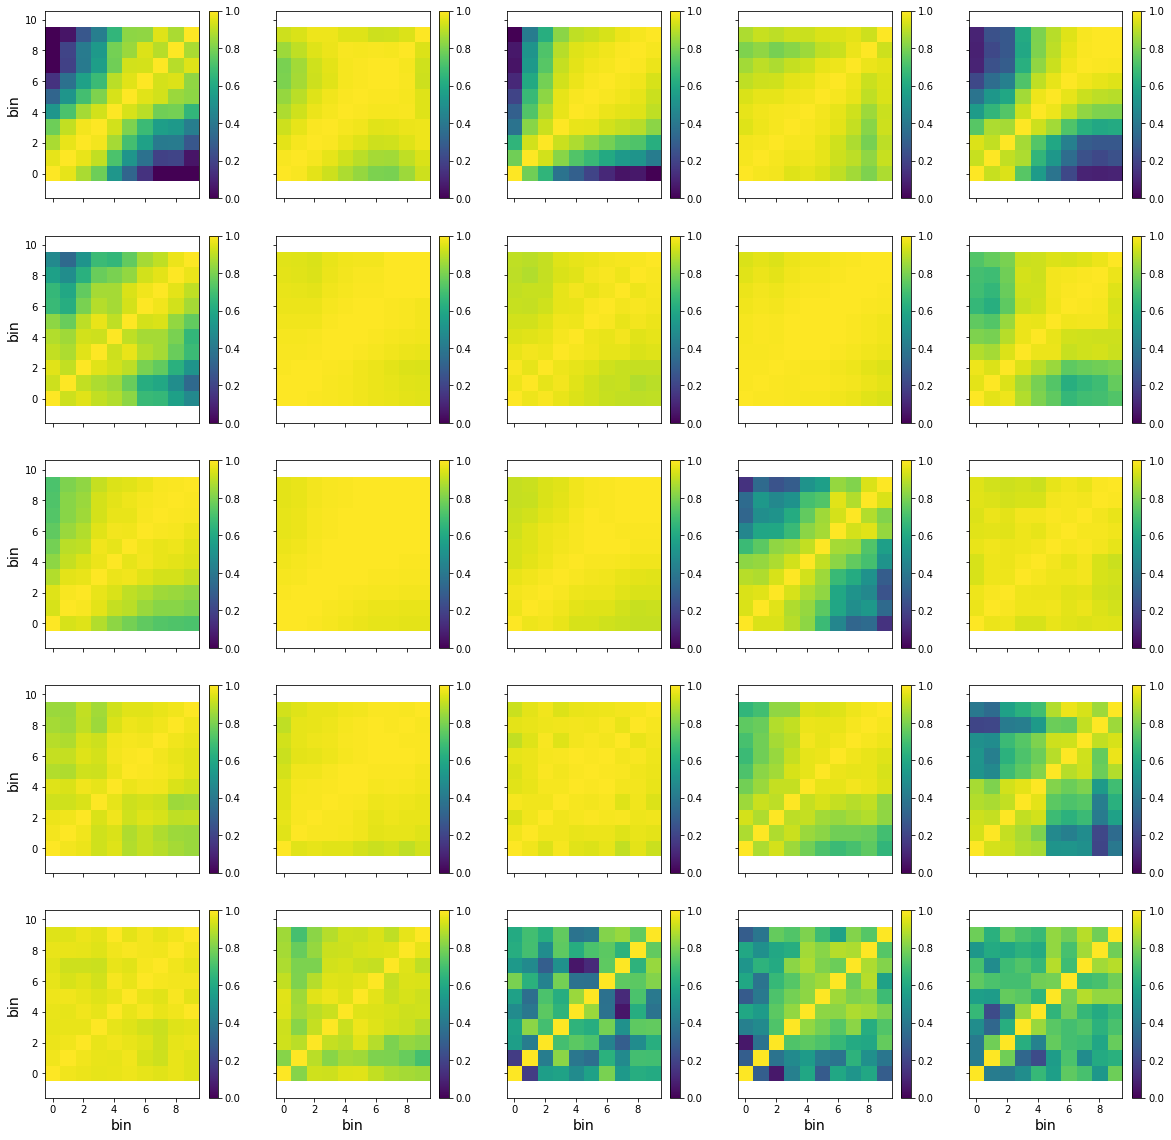

In [34]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20)) # graph correlation function for each z bin
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):      
        cax = ax[i, j].imshow(corr_def[rep[i] + j], aspect = 'equal',interpolation = None,vmin = 0, vmax = 1, origin = 'lower')
        fig.colorbar(cax , ax=ax[i, j])
        ax[4,j].set_xlabel('bin', fontsize= 14)
        ax[i,0].set_ylabel('bin', fontsize = 14)
#fig.savefig('picss.png')

In [35]:
sim = []
for d in range (0,25):
    sim.append(d)

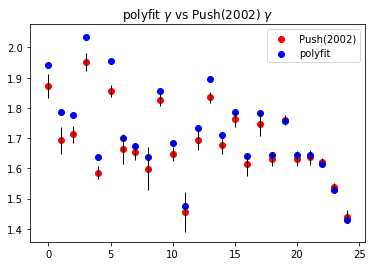

In [36]:
#graph A from polyfit vs A from push
pebg = plt.scatter (sim, fin_gamma, color = 'red')
polyg = plt.scatter (sim, g_value, color = 'blue')
plt.errorbar (sim, fin_gamma, yerr = fin_gerr,color='black', lw=1, ls='')
plt.title ('polyfit $\gamma$ vs Push(2002) $\gamma$')
plt.legend((pebg, polyg), ('Push(2002)', 'polyfit'))
plt.show()

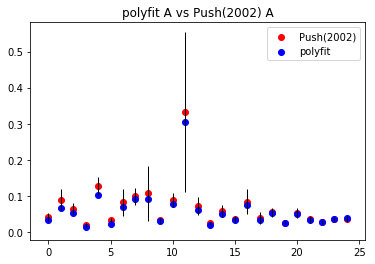

In [37]:
# comparison of polyfit vs Push
pebA = plt.scatter (sim, fin_A, color = 'red')
polyA = plt.scatter (sim, A_value, color = 'blue')
plt.errorbar (sim, fin_A, yerr = fin_Aerr,color='black', lw=1, ls='')
plt.title ('polyfit A vs Push(2002) A')
plt.legend((pebA, polyA), ('Push(2002)', 'polyfit'))
plt.show()

In [92]:
#write out file
csv = open ('des40a/output.info', 'w')
columnTitleRow = "ra_min\tra_max    dec_min   dec_max  zmin    zmax\t    A\t\t      gamma\n"
csv.write(columnTitleRow )
for i in range (0,25):
    A = ('%.4f  %.4f  %.4f  %.4f  %.4f  %.4f  %.4f +/- %.4f  %.4f +/- %.4f\n' 
         % (ra_min*180/numpy.pi, ra_max*180/numpy.pi, dec_min*180/numpy.pi, dec_max*180/numpy.pi, z_min[i], 
            z_max[i], fin_A[i], fin_Aerr[i], fin_gamma[i], fin_gerr[i]))
    csv.write(A)
csv.close()